In [29]:
!pip install plotly
!pip install psycopg2
!pip install sqlalchemy
!pip install -U kaleido

In [30]:
import plotly.express as px
import pandas as pd
import psycopg2
import os
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy import text
import plotly.io as pio
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'vscode'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

# 1 -Connect to the database

- Embed the credentials.
- Run the engine and create SQL commands to query the database. 
<hr>

In [3]:
redshift_endpoint = os.getenv('db_host')
redshift_user = os.getenv('db_user')
redshift_pass = os.getenv('db_password')
port = os.getenv('db_port')
dbname = os.getenv('db_name')

In [4]:
engine_login = f"postgresql+psycopg2://{redshift_user}:{redshift_pass}@{redshift_endpoint}:{port}/{dbname}"
engine = create_engine(engine_login)

# 2 - Lay out expectations

Want to know:
- How I tackle the problem
- Succinct communication of findings
- See the workings i.e. show you can use python and SQL.

I use python notebooks and DBeaver to query the database, although for readability I have left the sql queries within this notebook.

<hr>



### Are some segments of DICE fans retained better than others?

1. Define retention. We are working with an app so keep this in mind. 

2. Do you see any differences between groups/cohorts??

3. What other segments/data would you like to look into if you had more?

        - Gender, income, marital status, occupation
        - More granular location? As customers move?
        - Languages spoken, interests, personality traits
        - Social media data - to understand the motivation behind users and perhaps some kind of virality sharing metric.

<hr>
What we know about the data:
 
- __transactions__ gives data on the transaction that represents a fan’s __first__ purchase on DICE.
Note that __later transactions for the same users are not included.__
- __users__ gives some basic information about the fans registered with DICE.
- __events__ gives some top-level information on the events (gigs) listed on DICE.
- __event_genres__ gives a third level of classification (after event_type and event_category)
above.
- __user_activity__ is a daily record of activity for each user in the users table from 1 January 2019
or the date they registered, whichever is latest, to 31 December 2019. These are activities
occurring on the date shown, not a __cumulative total__. Users appear in this table every day after
they registered regardless of whether any activity was recorded

# 3 - Plan of attack

How to tackle the problem:

1. Familiarise myself with the dataset first.
    - What is the schema?
    - Number of rows and variables.
    - What are the keys and relationships?
    - What are the key stats from each table?
2. Define retention and look at the retention rate over time.
    - Create a cohort for the users first transactions in January and February respectively. 
3. Do some exploratary data analysis to look into which segmentation to look into. 
    - Look at age, genre, location and app type used. 
4. Create graphs looking at the retention of with these factors. 
5. Conclude/Think of next steps. 


I created this visual schema as a reference for when I was doing SQL joins:

<img src="ERD.jpg" width=1280 height=720 />

<hr>

#### Definition of retention
> We define retention as "the __percentage of users__ who continue __engaging__ with an app __over time__." 

> Retention – The level of engagement a customer has with the DICE app over time. 

We'll use the user_activity table to measure engagement. Any row that does not contain only zeros, will be classed as 'engagement'.

This boils down to:
 $\dfrac{number \: of \: active \: users \: over \: time}{number\: of \: users \:over \:time}$  

__An 'active user' or 'engagement' will be a user which has non-empty rows from the user_activity table.__

<hr>


# 5 - Retention rate over time. 
- Create January and February Cohorts of users and measure there engagement over time 

In [5]:
sql1= """
with jan_cohort as (
    select t.user_id as user_id
from analyst_task.transactions t 
    where date_part('month', t.time_stamp) = 1 and date_part('year', t.time_stamp) = 2019
),
new_customers as (
    select count(user_id) as jan_new_customers
    from jan_cohort
),
revisit as (
select 
    date_part('year', ua."date") as yr,
    date_part('month', ua."date") as mth,
    count (distinct ua.user_id) as num_engaged_users,
    count (ua.user_id) as num_interactions
from analyst_task.user_activity ua 
inner join jan_cohort on jan_cohort.user_id = ua.user_id 
    where yr=2019
    and greatest(count_events_viewed, count_events_saved, count_tickets_purchased, count_tickets_purchased_mobile, count_tickets_purchased_web, count_mobile_sessions, count_web_sessions, count_waitinglists_joined) >= 1
    group by yr, mth
)
select *
from revisit, new_customers
order by revisit.mth;
"""
df_jan_cohort = pd.read_sql_query(text(sql1), engine)


In [6]:
# Create the percentage engagement by dividing the number of engaged users by total users that month
df_jan_cohort['%_engagement'] = round(df_jan_cohort['num_engaged_users']/df_jan_cohort['jan_new_customers'] * 100, 2)
# interactions per user - divide the number of interactions by the users that are making the interactions 
df_jan_cohort['interactions_per_engaged_user'] = round(df_jan_cohort['num_interactions']/df_jan_cohort['num_engaged_users'], 2)
df_jan_cohort.head(12)

,yr,mth,num_engaged_users,num_interactions,jan_new_customers,%_engagement,interactions_per_engaged_user
0,2019.0,1.0,19547,45111,19558,99.94,2.31
1,2019.0,2.0,9760,26532,19558,49.90,2.72
2,2019.0,3.0,6964,19157,19558,35.61,2.75
3,2019.0,4.0,4971,12465,19558,25.42,2.51
4,2019.0,5.0,4759,13066,19558,24.33,2.75
5,2019.0,6.0,3867,9551,19558,19.77,2.47
6,2019.0,7.0,3459,8612,19558,17.69,2.49
7,2019.0,8.0,3052,7555,19558,15.60,2.48
8,2019.0,9.0,3229,8287,19558,16.51,2.57
9,2019.0,10.0,3336,9484,19558,17.06,2.84


#### Similar query for February

In [7]:
sql2= """
with feb_cohort as (
    select t.user_id as user_id
from analyst_task.transactions t 
    where date_part('month', t.time_stamp) = 2
),
new_customers as (
    select count(user_id) as feb_new_customers
    from feb_cohort
),
revisit as (
select 
    date_part('year', ua."date") as yr,
    date_part('month', ua."date") as mth,
    count (distinct ua.user_id) as num_engaged_users,
    count (ua.user_id) as num_interactions
from analyst_task.user_activity ua 
inner join feb_cohort on feb_cohort.user_id = ua.user_id 
    where yr=2019
    and greatest(count_events_viewed, count_events_saved, count_tickets_purchased, count_tickets_purchased_mobile, count_tickets_purchased_web, count_mobile_sessions, count_web_sessions, count_waitinglists_joined) >= 1
    and mth >= 2
    group by yr, mth

)
select *
from revisit, new_customers
order by revisit.mth;
"""
df_feb_cohort = pd.read_sql_query(text(sql2), engine)


In [8]:
# Create the percentage engagement by dividing the number of engaged users by total users that month
df_feb_cohort['%_engagement'] = round(df_feb_cohort['num_engaged_users']/df_feb_cohort['feb_new_customers'] * 100, 2)
df_feb_cohort['interactions_per_engaged_user'] = round(df_feb_cohort['num_interactions']/df_feb_cohort['num_engaged_users'], 2)
df_feb_cohort.head(12)

,yr,mth,num_engaged_users,num_interactions,feb_new_customers,%_engagement,interactions_per_engaged_user
0,2019.0,2.0,23843,55853,23852,99.96,2.34
1,2019.0,3.0,10504,28601,23852,44.04,2.72
2,2019.0,4.0,7105,17340,23852,29.79,2.44
3,2019.0,5.0,6263,16410,23852,26.26,2.62
4,2019.0,6.0,4793,11853,23852,20.09,2.47
5,2019.0,7.0,4261,10482,23852,17.86,2.46
6,2019.0,8.0,3771,9148,23852,15.81,2.43
7,2019.0,9.0,3835,9657,23852,16.08,2.52
8,2019.0,10.0,3906,10962,23852,16.38,2.81
9,2019.0,11.0,3881,10767,23852,16.27,2.77


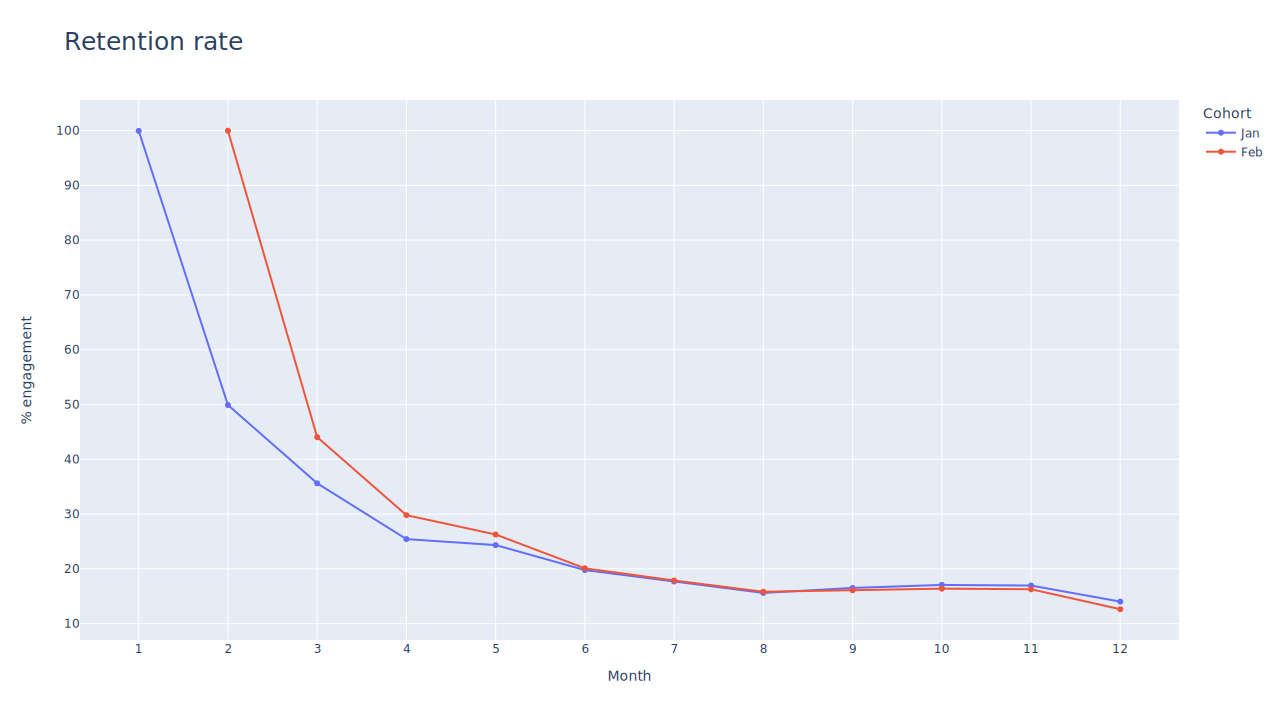

In [9]:
import plotly.graph_objects as go

dfs = {"Jan" : df_jan_cohort, "Feb": df_feb_cohort} # place the two dataframes into a dictionary to loop over them and then plot the points
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i]['mth'],
                                   y = dfs[i]['%_engagement'], 

                                   name = i))

#Layout
fig.update_layout(title = "Retention rate", title_font_size=25, legend_title_text = "Cohort")
fig.update_xaxes(title_text='Month', dtick = 1)
fig.update_yaxes(title_text='% engagement')
fig.show(renderer="svg", width=1280, height=720)

<ul>
    <li>Jan_New_Customers = 19558</li>
    <li>Feb_New_Customers = 23852</li>
</ul>
Similar retention after 11 to 12 months for both cohorts despite having different sized cohorts.

<hr>
<br>
The largest drop off in engagement is after one month for both Jan and Feb cohorts. 

<ul>
    <li>Jan: 50% drop after one month.</li>
    <li>Feb: 56% drop after one month.</li>
</ul>

<br>
<hr>
After 11 months:
<ul>
    <li>Jan: 17% have been retained (i.e. still engage with the app)</li>
    <li>Feb: 12.6% have been retained (i.e. still engage with the app)</li>
</ul>

From this we can see that the <strong>users that bought tickets in January have a higher engagement rate</strong>.

Pattern becomes more seasonal around 4-5 months as we can see from the graph. 


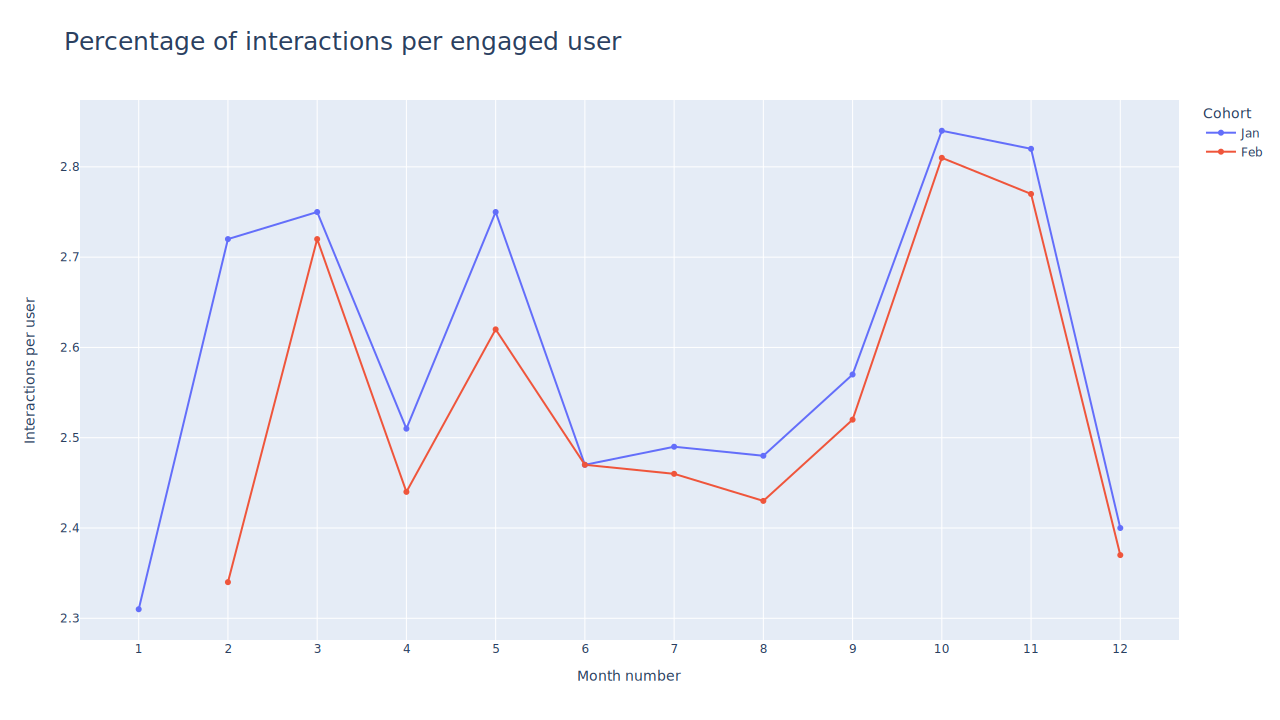

In [10]:
dfs = {"Jan" : df_jan_cohort, "Feb": df_feb_cohort}
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i]['mth'],
                                   y = dfs[i]['interactions_per_engaged_user'], 

                                   name = i))
    
fig.update_layout(title = "Percentage of interactions per engaged user", title_font_size=25, legend_title_text = "Cohort")
fig.update_xaxes(title_text='Month number', dtick = 1)
fig.update_yaxes(title_text='Interactions per user')
fig.show(renderer="svg", width=1280, height=720)

#### There is a higher number of interactions per engaged user for the months of September, October and November 2019. This could denote some kind of marketing campaign around the final months of the year. This keeps the users more engaged and returning to the app. 

- First month lower for each cohort as the first use of the app can occur at any point in the month i.e 1st or 31st

# 6 - Look at the Age of the users
1. Age of the January and February cohorts.
2. Look at the age of the users and the engagement with DICE over time.

In [11]:
sql3= """
select
    u.user_id,
    u.date_of_birth,
    current_date
from analyst_task.users u
inner join analyst_task.transactions t
    on u.user_id = t.user_id
    where date_part('month', t.time_stamp) = 1 and date_part('year', t.time_stamp) = 2019
"""
jan_cohort_age = pd.read_sql_query(text(sql3), engine)


In [12]:
# change to pandas series columns to datetime 
jan_cohort_age['date_of_birth'] = pd.to_datetime(jan_cohort_age['date_of_birth'], errors='coerce') 
jan_cohort_age['date'] = pd.to_datetime(jan_cohort_age['date'], errors='coerce')

# subtract todays date from 
jan_cohort_age['age'] = (jan_cohort_age['date'] - jan_cohort_age['date_of_birth']) // np.timedelta64(1, 'Y')

### Place users into age groups 
- Under 18
- 19_to_25
- 26_to_30
- 31_to_40
- 41_to_50
- Over 50

Count the number of users in each age group

In [13]:
jan_cohort_age['age_groups'] = pd.cut(jan_cohort_age['age'], bins=(0,18,25,30,40,50,np.inf), labels=['Under 18','19_to_25','26_to_30','31_to_40','41_to_50','Over 50'])
age_counts = jan_cohort_age['age_groups'].value_counts()
age_counts

26_to_30    5895
31_to_40    5726
19_to_25    4482
41_to_50    1755
Over 50     1121
Under 18      32
Name: age_groups, dtype: int64

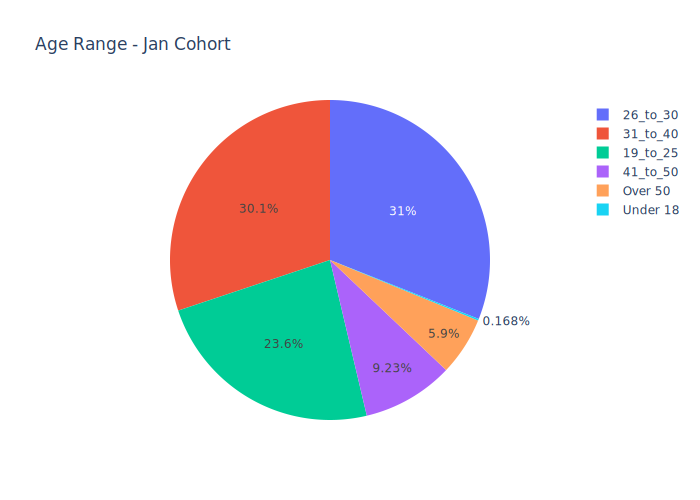

In [14]:
fig = px.pie(jan_cohort_age, values=age_counts, names = age_counts.keys(), title='Age Range - Jan Cohort')
fig.show(renderer="svg")

#### Similarly for the February cohort

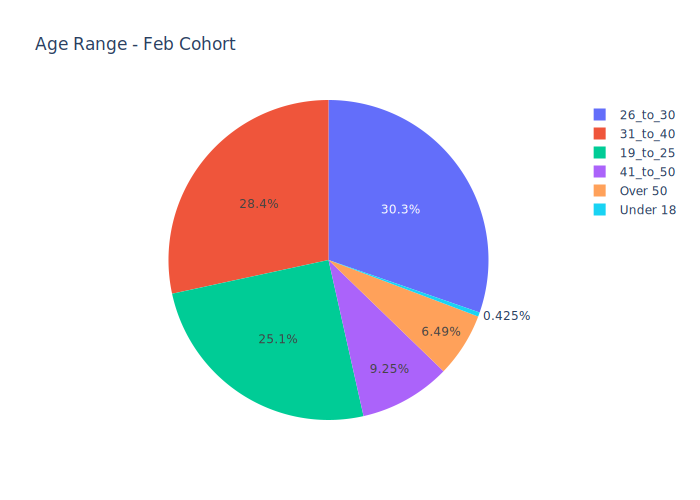

In [15]:
sql4 = """
select
    u.user_id,
    u.date_of_birth,
    current_date
from analyst_task.users u
inner join analyst_task.transactions t
    on u.user_id = t.user_id
    where date_part('month', t.time_stamp) = 2 and date_part('year', t.time_stamp) = 2019
"""
df4 = pd.read_sql_query(text(sql4), engine)
df4['date_of_birth'] = pd.to_datetime(df4['date_of_birth'], errors='coerce')
df4['date'] = pd.to_datetime(df4['date'], errors='coerce')
df4['age'] = (df4['date'] - df4['date_of_birth']) // np.timedelta64(1, 'Y')
df4['age_groups'] = pd.cut(df4['age'], bins=(0,18,25,30,40,50,np.inf), labels=['Under 18','19_to_25','26_to_30','31_to_40','41_to_50','Over 50'])
age_counts_feb = df4['age_groups'].value_counts()

fig = px.pie(df4, values=age_counts_feb, names = age_counts.keys(), title='Age Range - Feb Cohort')
fig.show(renderer="svg")

#### What do we know so far?
- We know that the january cohort has a higher retention rate and 17% of the users still engage with the app after 11 months compared to Februaries 12.6% after 11 months. 
- February has 4,294 more __new__ users than Jan.

- The age groups for January and February have similar proportions of the total users. Namely, the __26 to 30 age group__ makes up the largest proportion of users for both months and ~85% of users are below the age of 40. (jan - 84.7% and feb - 83.3%).

# 7 - January cohort
Let's look at the retention of number of users by age group. 

In this section, we'll also __look at for the January cohort__ (similar method for the feb cohort):
- purchase_app_type
- genre
- venue type

In [16]:
# query for the new customers in jan and with there user ids -- not the count, so need to get rid of the group by year and month aggregations

sql7 = """
with jan_cohort as (
    select t.user_id as user_id
from analyst_task.transactions t 

where date_part('month', t.time_stamp) = 1 and date_part('year', t.time_stamp) = 2019
),

revisit as (
select 
    ua.user_id,
    date_part('year', ua."date") as yr,
    date_part('month', ua."date") as mth,
    count (distinct ua.user_id) as num_engaged_users,
    count (ua.user_id) as num_interactions
from analyst_task.user_activity ua 
inner join jan_cohort on jan_cohort.user_id = ua.user_id 
    where yr=2019
    and greatest(count_events_viewed, count_events_saved, count_tickets_purchased, count_tickets_purchased_mobile, count_tickets_purchased_web, count_mobile_sessions, count_web_sessions, count_waitinglists_joined) >= 1
    group by yr, mth, ua.user_id
)
select *
from revisit
order by revisit.mth;
"""
jan_cohort_user_ids = pd.read_sql_query(text(sql7), engine)

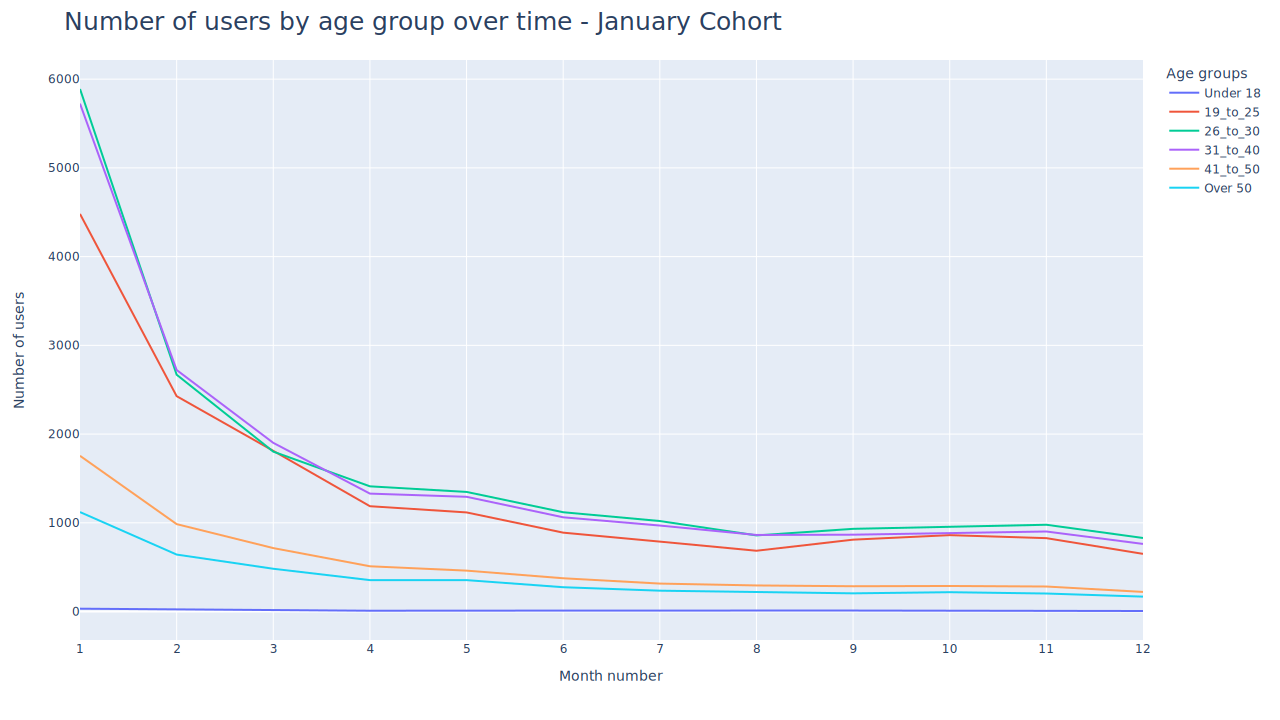

In [17]:
df_jan_users_and_age = pd.merge(jan_cohort_user_ids,jan_cohort_age,on='user_id') #inner join with the january age dataframe and the query of january users with their ids
df_jan_users_and_age.drop(columns=['date_of_birth', 'date', 'age'], inplace= True) # drop unwanted columns

grouped_users_age = df_jan_users_and_age.groupby(['mth', 'age_groups']).size() # group by month and age group and count the number in each age group by month
df_group_users_age = grouped_users_age.to_frame()
df_group_users_age.rename(columns = {0:'Number_of_users'}, inplace = True)
df_group_users_age.reset_index(level=['mth', 'age_groups'], inplace = True)

#Graph using plotly
fig = px.line(df_group_users_age, x='mth', y='Number_of_users', color='age_groups')
fig.update_layout(title = "Number of users by age group over time - January Cohort", title_font_size=25, legend_title_text = "Age groups")
fig.update_xaxes(title_text='Month number', dtick = 1)
fig.update_yaxes(title_text='Number of users')
fig.show(renderer="svg", width=1280, height=720)

# Genre, purchase app type and venues
- Create a query that gets all this information into one table for January.

In [18]:
#need three inner joins on event_id

sql5 = """
select 
    t.user_id,
    t.event_id,
    t.purchase_app_type, 
    eg.genre,
    e.venue_country,
    e.venue_city,
    e.event_category
    
from analyst_task.transactions t 
    
inner join analyst_task.event_genres eg
    on eg.event_id = t.event_id
inner join analyst_task.events e
    on t.event_id = e.event_id

where date_part('month', t.time_stamp) = 1 and date_part('year', t.time_stamp) = 2019
"""
jan_info = pd.read_sql_query(text(sql5), engine)
jan_info.head()

,user_id,event_id,purchase_app_type,genre,venue_country,venue_city,event_category
0,6f011c11d2256907259c0be1a744e95c,9ad3b55a2e774ae6ed8115f2326e63e4,mobile_app,hiphop,United States,New York,party
1,6f011c11d2256907259c0be1a744e95c,9ad3b55a2e774ae6ed8115f2326e63e4,mobile_app,rap,United States,New York,party
2,6f011c11d2256907259c0be1a744e95c,9ad3b55a2e774ae6ed8115f2326e63e4,mobile_app,trap,United States,New York,party
3,935c444fdc8b51f39b0e7b2a167a474b,bd99db27fa52ed82935af4b44d0f9d79,web_app,metal,United States,Los Angeles,gig
4,935c444fdc8b51f39b0e7b2a167a474b,bd99db27fa52ed82935af4b44d0f9d79,web_app,hardcore,United States,Los Angeles,gig


In [19]:
#Table for app_type in jan
purchase_type = jan_info.groupby(['purchase_app_type']).size()
df_type = purchase_type.to_frame()
df_type.rename(columns = {0:'Number_of_users'}, inplace = True)
df_type.reset_index(inplace = True)

df_type.head()

,purchase_app_type,Number_of_users
0,mobile_app,21020
1,web_app,27963


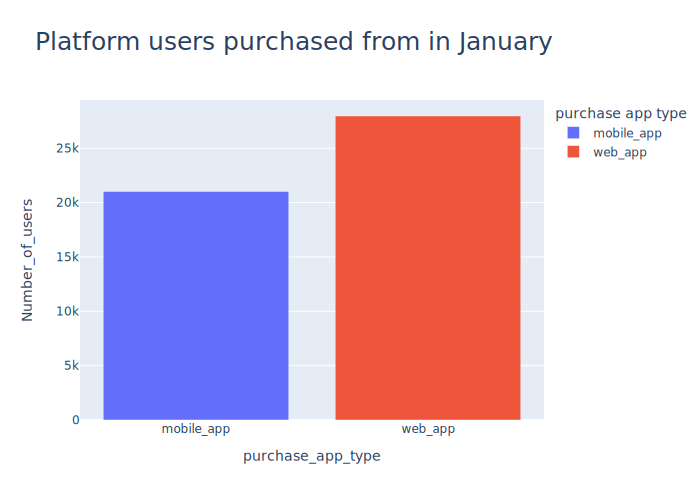

In [20]:
fig = px.bar(df_type, x='purchase_app_type', y='Number_of_users', color = 'purchase_app_type', title = 'Platform users purchased from in January')
fig.update_layout(title = 'Platform users purchased from in January', title_font_size=25, legend_title_text = "purchase app type")
fig.show(renderer="svg")

In [21]:
df_jan = pd.merge(jan_cohort_user_ids,jan_info,on='user_id')
df_jan.head()

,user_id,yr,mth,num_engaged_users,num_interactions,event_id,purchase_app_type,genre,venue_country,venue_city,event_category
0,01911fcfd69ab3325ccc3ed7911c656d,2019.0,1.0,1,1,0f737e3d58eac39fa6d7d1a31963fe6a,mobile_app,disco,France,Paris,party
1,01911fcfd69ab3325ccc3ed7911c656d,2019.0,1.0,1,1,0f737e3d58eac39fa6d7d1a31963fe6a,mobile_app,funk,France,Paris,party
2,01911fcfd69ab3325ccc3ed7911c656d,2019.0,1.0,1,1,0f737e3d58eac39fa6d7d1a31963fe6a,mobile_app,soul,France,Paris,party
3,038a75c9ebae7a00dd1f256890baab30,2019.0,1.0,1,2,7b0f98c9827941178ac24698c65a03d1,web_app,dance,United Kingdom,London,party
4,038a75c9ebae7a00dd1f256890baab30,2019.0,3.0,1,1,7b0f98c9827941178ac24698c65a03d1,web_app,dance,United Kingdom,London,party


In [22]:
# three dataframes for app type, country, genre using the same method as above

grouped_app_type = df_jan.groupby(['mth', 'purchase_app_type']).size()
df_app_type = grouped_app_type.to_frame()
df_app_type.rename(columns = {0:'Number_of_users'}, inplace = True)
df_app_type.reset_index(level=['mth', 'purchase_app_type'], inplace = True)

grouped_country = df_jan.groupby(['mth', 'venue_country']).size()
df_country = grouped_country.to_frame()
df_country.rename(columns = {0:'Number_of_users'}, inplace = True)
df_country.reset_index(level=['mth', 'venue_country'], inplace = True)

grouped_genre = df_jan.groupby(['mth', 'genre']).size()
df_genre = grouped_genre.to_frame()
df_genre.rename(columns = {0:'Number_of_users'}, inplace = True)
df_genre.reset_index(level=['mth', 'genre'], inplace = True)

## Retention based on purchase app type

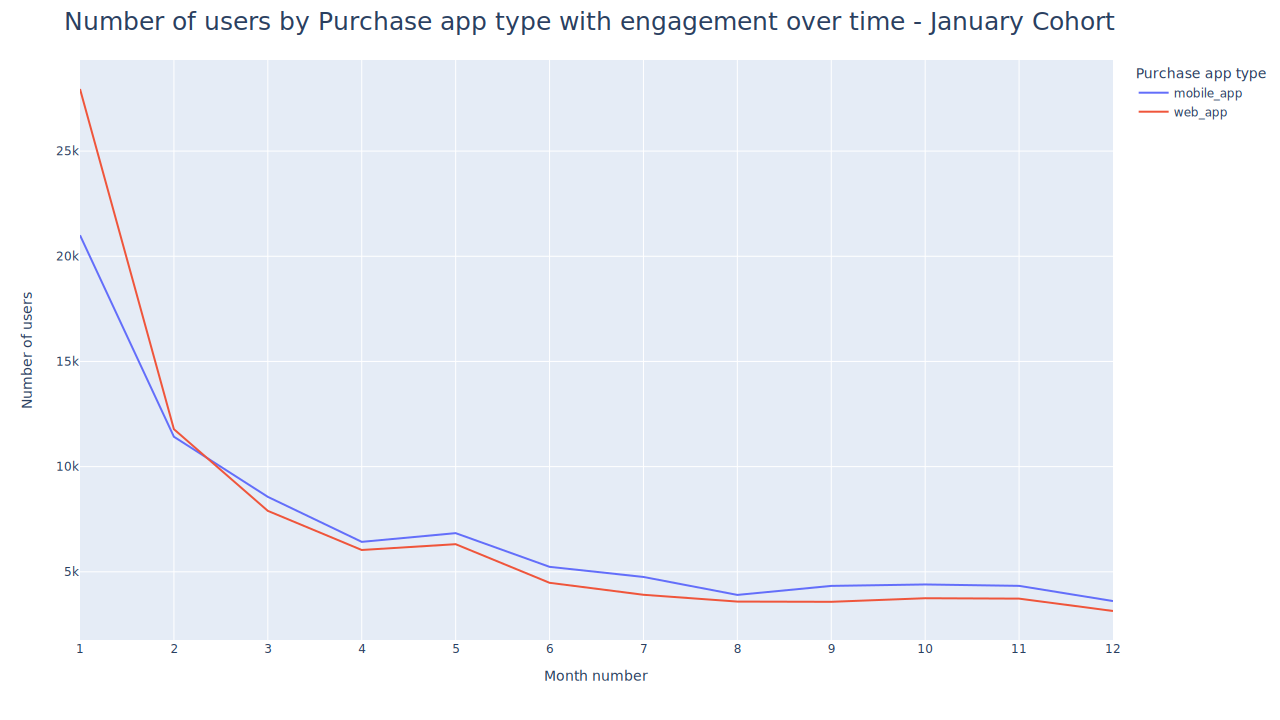

In [23]:
fig = px.line(df_app_type, x='mth', y='Number_of_users', color='purchase_app_type')
fig.update_layout(title = "Number of users by Purchase app type with engagement over time - January Cohort", title_font_size=25, legend_title_text = "Purchase app type")
fig.update_xaxes(title_text='Month number', dtick = 1)
fig.update_yaxes(title_text='Number of users')
fig.show(renderer="svg", width=1280, height=720)

## Retention based on Country

In [24]:
jan_info['venue_country'].unique().tolist()

['United States',
 'United Kingdom',
 'France',
 'Ireland',
 '',
 'Germany',
 'Malta']

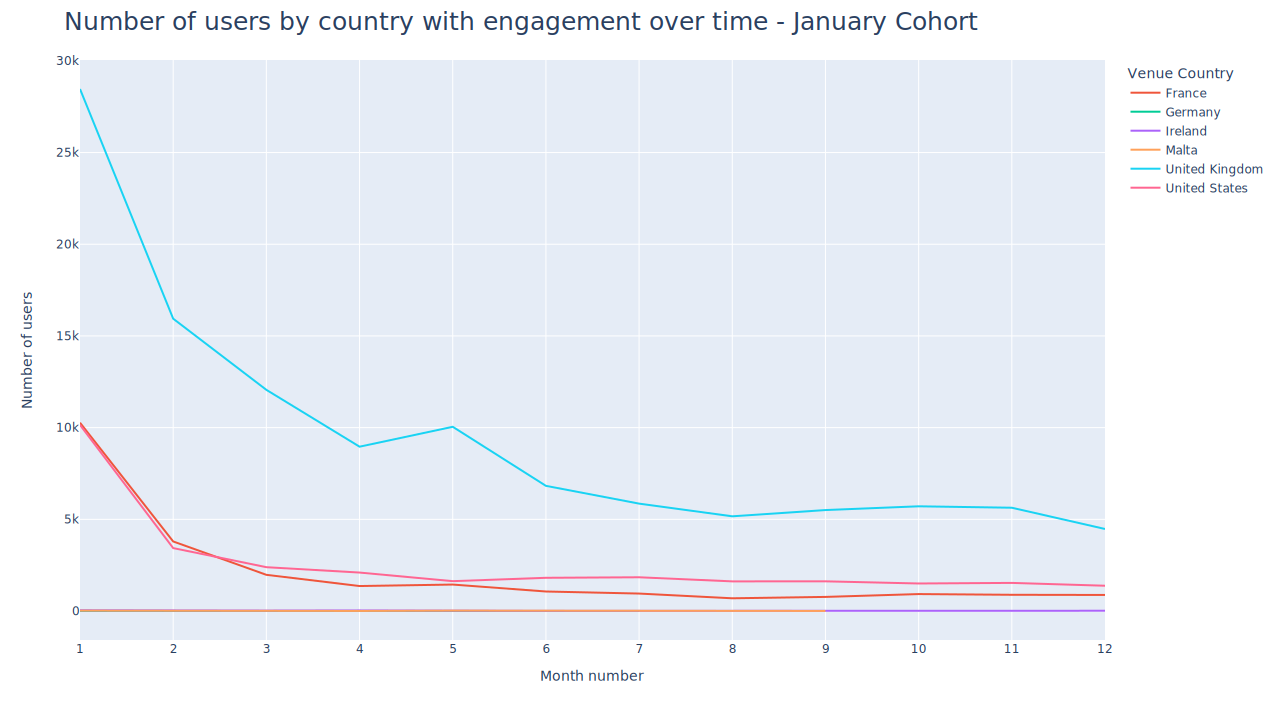

In [25]:
fig = px.line(df_country, x='mth', y='Number_of_users', color='venue_country')
fig.update_layout(title = 'Number of users by country with engagement over time - January Cohort', title_font_size=25, legend_title_text = "Venue Country")
fig.update_xaxes(title_text='Month number', dtick = 1)
fig.update_yaxes(title_text='Number of users')
fig.show(renderer="svg", width=1280, height=720)

## Retention based on Genre

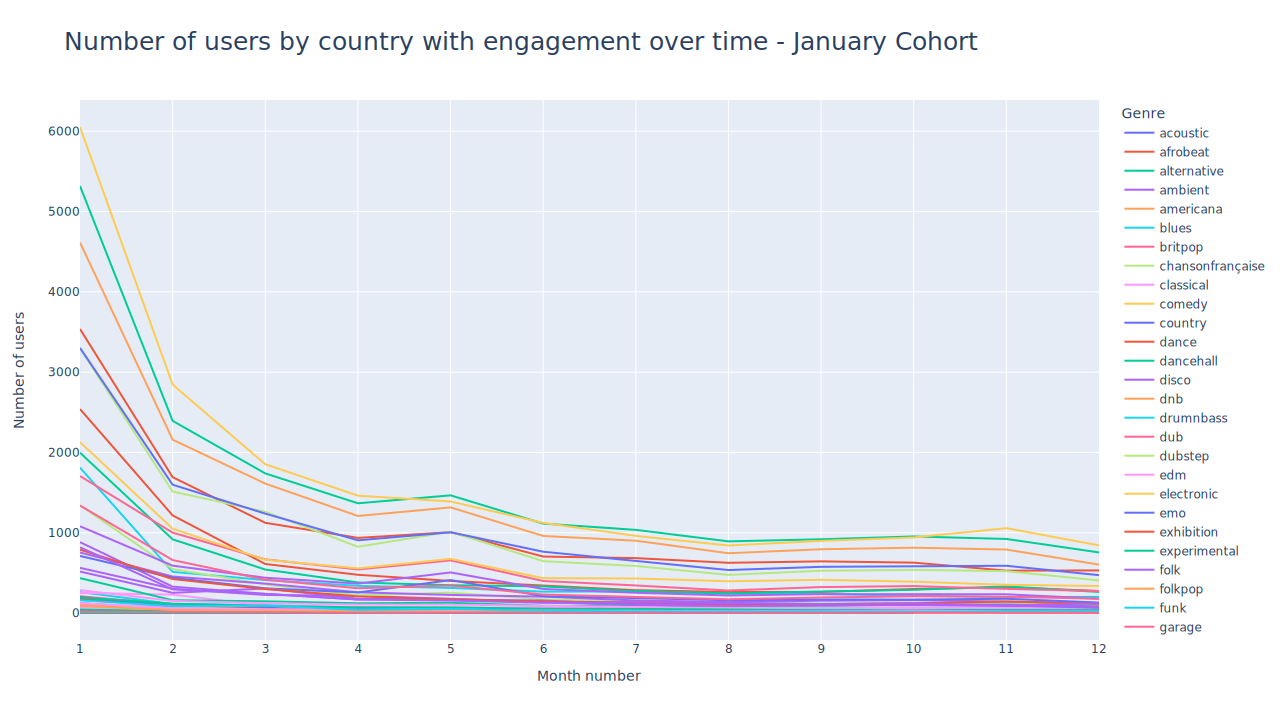

In [31]:
fig = px.line(df_genre, x='mth', y='Number_of_users', color='genre', title = 'Number of users by genre based on engagement over time - January Cohort')
fig.update_layout(title = 'Number of users by country with engagement over time - January Cohort', title_font_size=25, legend_title_text = "Genre")
fig.update_xaxes(title_text='Month number', dtick = 1)
fig.update_yaxes(title_text='Number of users')
fig.show(renderer="svg", width=1280, height=720)

# Filter dataframe for the United Kingdom

- Quick look at the rentention rate of each city based in the UK.

In [27]:
jan_uk = df_jan[df_jan['venue_country'] == 'United Kingdom']

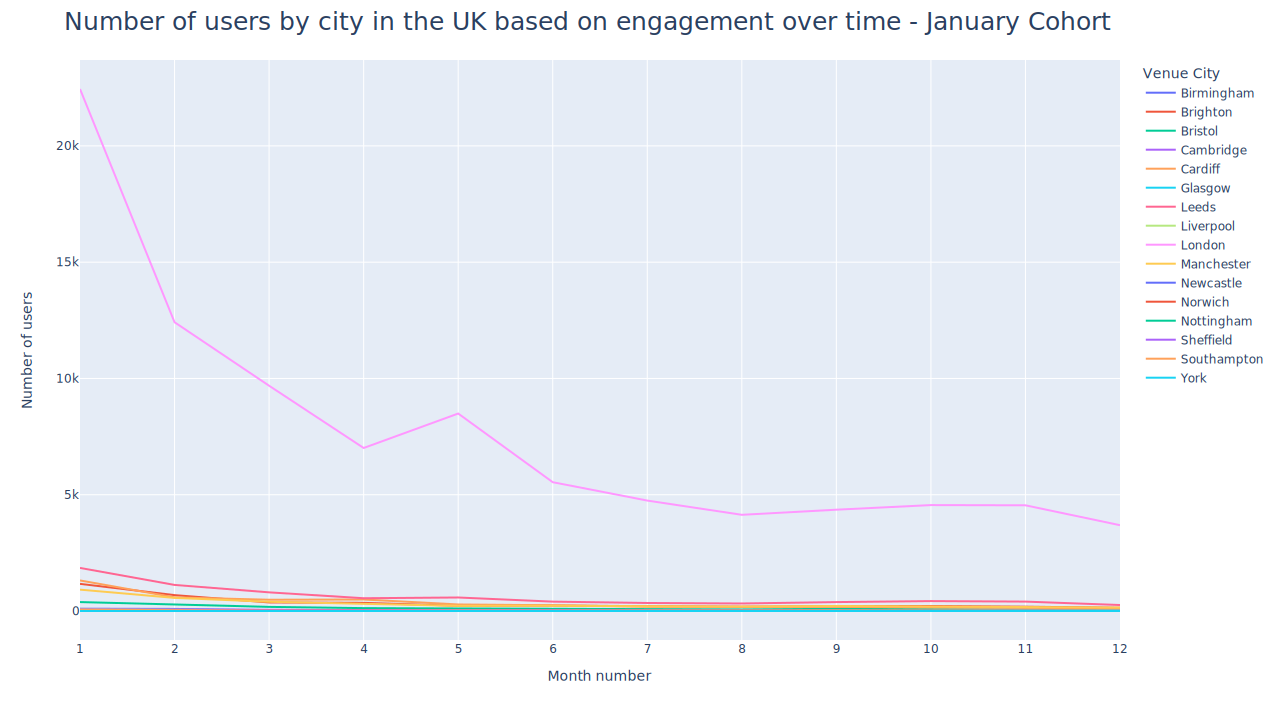

In [28]:
# same method as above but using the filtered dataframe for the UK

grouped_city = jan_uk.groupby(['mth', 'venue_city']).size()
df_uk_city = grouped_city.to_frame()
df_uk_city.rename(columns = {0:'Number_of_users'}, inplace = True)
df_uk_city.reset_index(level=['mth', 'venue_city'], inplace = True)

fig = px.line(df_uk_city, x='mth', y='Number_of_users', color='venue_city')
fig.update_layout(title = 'Number of users by city in the UK based on engagement over time - January Cohort', title_font_size=25, legend_title_text = "Venue City")
fig.update_xaxes(title_text='Month number', dtick = 1)
fig.update_yaxes(title_text='Number of users')
fig.show(renderer="svg", width=1280, height=720)

## What can we infer from these retention graphs of the users that signed up in January?

##### Purchase app type:
- More users make their first purchase on the web and these users have a high drop off of 42.1% in the first month. Which makes sense as it implies that they are not using the app. 
- The retention of both the app and web users (these are simply users that bought their first ticket on the web) are the very similar after the second month after purchase. This suggests that a lot of the web users downloaded the app.

##### Venue country:
- The top three countries in terms of number of users is UK, France and US. With the UK being the country that adopts DICE as a ticketing and experience service the most. 
- In the UK, in May 11% of the users that bought a ticket in January returned to the app after leaving it for 4 months. 8961 users in April and 10046 in May. This explains the increase in the UK curve. This would need further investigation.

##### Genre
- Alternative, electronic and indie are the genres that retain the highest percentage of users for the customers that bought in January (in terms of engagement with the app).

##### Cities in the UK
- London has the highest proportion of users compared to the rest of the country, it also has the highest retention. It has the same increase in engagement from April to May. This suggests something happed in May 2019 in London which agrees with the country retention graph. 

# Extensions:
More data:
- Create a cohort table for each month
- Create similar analysis for each month

More time:
- Frequency of use i.e. daily, weekly, monthly frequency. How many users are using the app monthly?
- Create a correlation matrix between the retention percentage and other metrics using seaborn
- Drill down into specific segments i.e. genre + age_range + purchase_app_type
- Look at retention of users that joined a waiting list